In [1]:
import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import seaborn as sns

In [2]:
df=pd.read_csv('spam.csv')

In [3]:
df

Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

In [4]:
df.Category.value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
spams=df[df['Category']=='spam']
#spams=spams.sample(100)

In [6]:
hams=df[df['Category']=='ham']

In [7]:
spams.shape

(747, 2)

In [8]:
hams.shape

(4825, 2)

In [9]:
hams_down_sample=hams.sample(spams.shape[0])

In [10]:
hams_down_sample.shape

(747, 2)

In [11]:
hams_down_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 3244 to 5398
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  747 non-null    object
 1   Message   747 non-null    object
dtypes: object(2)
memory usage: 17.5+ KB


In [12]:
balanced_df=pd.concat([spams,hams_down_sample])

In [13]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1494 entries, 2 to 5398
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  1494 non-null   object
 1   Message   1494 non-null   object
dtypes: object(2)
memory usage: 35.0+ KB


In [14]:
balanced_df.Category.value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

<Axes: xlabel='Category', ylabel='count'>

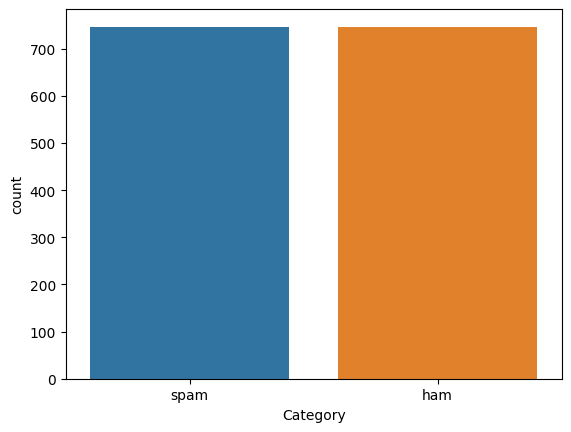

In [15]:
sns.countplot(x=balanced_df['Category'])

In [16]:
balanced_df['spam']=balanced_df.Category.apply(lambda x:1 if x=='spam' else 0)

In [17]:
balanced_df.sample(5)

Category                                            Message  spam
1069     spam  Someone U know has asked our dating service 2 ...     1
2085      ham             How are you. Wish you a great semester     0
2095     spam  PRIVATE! Your 2004 Account Statement for 07742...     1
5407      ham  Yup he msg me: is tat yijue? Then i tot it's m...     0
2121      ham  Argh my 3g is spotty, anyway the only thing I ...     0

In [18]:
preprocess_url="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_preprocessor=hub.KerasLayer(preprocess_url)
bert_encoder=hub.KerasLayer(encoder_url)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-06-30 12:05:07.338157: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [19]:
input_layer=tf.keras.layers.Input(shape=(),dtype=tf.string,name="input_text")
preprocess_text_layer=bert_preprocessor(input_layer)
encoder_layer=bert_encoder(preprocess_text_layer)
dropout_layer=tf.keras.layers.Dropout(0.1, name='dropout_1')(encoder_layer['pooled_output'])
output_layer=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(dropout_layer)
model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_text[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [21]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test=train_test_split(balanced_df['Message'], balanced_df['spam'],test_size=0.33,stratify=balanced_df['spam'])

In [23]:
X_train.shape

(1000,)

In [24]:
X_test.shape

(494,)

In [25]:
374/1120

0.3339285714285714

In [26]:
history=model.fit(X_train,y_train,epochs=10, validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 79s 3s/step - loss: 0.6507 - accuracy: 0.6350 - precision: 0.6399 - recall: 0.6739 - val_loss: 0.6091 - val_accuracy: 0.6750 - val_precision: 0.5714 - val_recall: 0.9767
Epoch 2/10
25/25 [==============================] - 68s 3s/step - loss: 0.5535 - accuracy: 0.7937 - precision: 0.7610 - recall: 0.8768 - val_loss: 0.4862 - val_accuracy: 0.8800 - val_precision: 0.8523 - val_recall: 0.8721
Epoch 3/10
25/25 [==============================] - 68s 3s/step - loss: 0.4800 - accuracy: 0.8462 - precision: 0.8473 - recall: 0.8575 - val_loss: 0.4294 - val_accuracy: 0.9000 - val_precision: 0.9231 - val_recall: 0.8372
Epoch 4/10
25/25 [==============================] - 68s 3s/step - loss: 0.4316 - accuracy: 0.8675 - precision: 0.8468 - recall: 0.9082 - val_loss: 0.3956 - val_accuracy: 0.8950 - val_precision: 0.8652 - val_recall: 0.8953
Epoch 5/10
25/25 [==============================] - 68s 3s/step - loss: 0.3969 - accuracy: 0.8900 - precision: 0

In [27]:
y_predicted=model.predict(X_test)

16/16 [==============================] - 38s 2s/step


In [28]:
import numpy as np
import matplotlib.pylab as plt


In [29]:
y_predicted=np.where(y_predicted>=0.5,1,0)

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
cm=confusion_matrix(y_test,y_predicted)

In [32]:
cm

array([[228,  19],
       [ 25, 222]])

Text(50.722222222222214, 0.5, 'Truth')

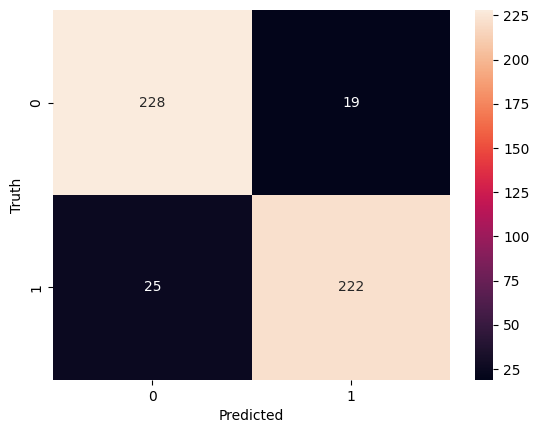

In [33]:
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [34]:
history_df=pd.DataFrame(history.history)

In [35]:
history_df

loss  accuracy  precision    recall  val_loss  val_accuracy  \
0  0.650692   0.63500   0.639908  0.673913  0.609146         0.675   
1  0.553520   0.79375   0.761006  0.876812  0.486196         0.880   
2  0.480042   0.84625   0.847255  0.857488  0.429429         0.900   
3  0.431562   0.86750   0.846847  0.908213  0.395582         0.895   
4  0.396883   0.89000   0.875576  0.917874  0.364369         0.910   
5  0.374776   0.88625   0.871264  0.915459  0.355068         0.895   
6  0.350895   0.88500   0.869266  0.915459  0.333679         0.905   
7  0.343590   0.88250   0.879147  0.896135  0.319117         0.910   
8  0.322702   0.89375   0.881671  0.917874  0.300142         0.915   
9  0.312667   0.89875   0.888112  0.920290  0.292312         0.910   

   val_precision  val_recall  
0       0.571429    0.976744  
1       0.852273    0.872093  
2       0.923077    0.837209  
3       0.865169    0.895349  
4       0.904762    0.883721  
5       0.849462    0.918605  
6       0.868132    0.918605  
7       0.877778    0.918605  
8       0.896552    0.906977  
9       0.877778    0.918605

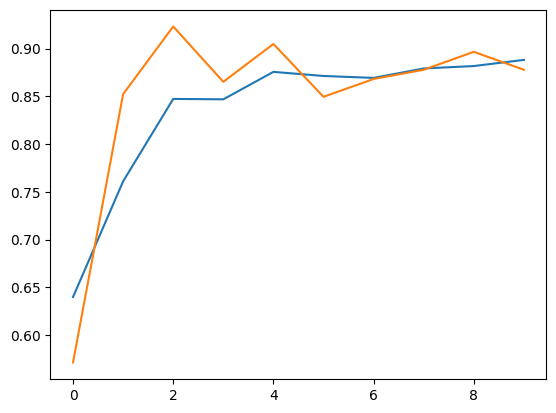

In [36]:
plt.plot(history_df['precision'])
plt.plot(history_df['val_precision'])

In [37]:
model.save("./model")

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


In [38]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       247
           1       0.92      0.90      0.91       247

    accuracy                           0.91       494
   macro avg       0.91      0.91      0.91       494
weighted avg       0.91      0.91      0.91       494



In [39]:
sample_dataset = [
 'You can win a lot of money, register in the link below',
 'You have an iPhone 10, spin the image below to claim your prize and it will be delivered in your door step',
 'You have an offer, the company will give you 50% off on every item purchased.',
 "Hey Bravin, don't be late for the meeting tomorrow will start lot exactly 10:30 am",
 "See you monday, we have alot to talk about the future of this company ."
]
p=model.predict(sample_dataset)

1/1 [==============================] - 3s 3s/step


In [40]:
p=np.where(p>=0.5,1,0)

In [41]:
p

array([[1],
       [1],
       [1],
       [1],
       [0]])

In [42]:
preprocess_text_layer['input_mask'].shape

TensorShape([None, 128])

In [43]:
model.layers[2].get_weights()

[array([[-0.01018257, -0.06154883, -0.02649689, ..., -0.01985357,
         -0.03720997, -0.00975152],
        [-0.01170495, -0.06002603, -0.03233192, ..., -0.01681456,
         -0.04009988, -0.0106634 ],
        [-0.01975381, -0.06273633, -0.03262176, ..., -0.01650258,
         -0.04198876, -0.00323178],
        ...,
        [-0.02176224, -0.0556396 , -0.01346345, ..., -0.00432698,
         -0.0151355 , -0.02489496],
        [-0.04617237, -0.05647721, -0.00192082, ...,  0.01568751,
         -0.01387033, -0.00945213],
        [ 0.00145601, -0.08208051, -0.01597912, ..., -0.00811687,
         -0.04746607,  0.07527421]], dtype=float32),
 array([[ 1.7505383e-02, -2.5631009e-02, -3.6641564e-02, ...,
          3.3437202e-05,  6.8312453e-04,  1.5441139e-02],
        [ 7.7580423e-03,  2.2613001e-03, -1.9444324e-02, ...,
          2.8909724e-02,  2.9752752e-02, -5.3246655e-03],
        [-1.1287465e-02, -1.9644140e-03, -1.1572698e-02, ...,
          1.4907907e-02,  1.8740905e-02, -7.3139993e-03]

In [44]:
! pip install pydot

In [45]:
model=tf.keras.models.load_model("model")

model

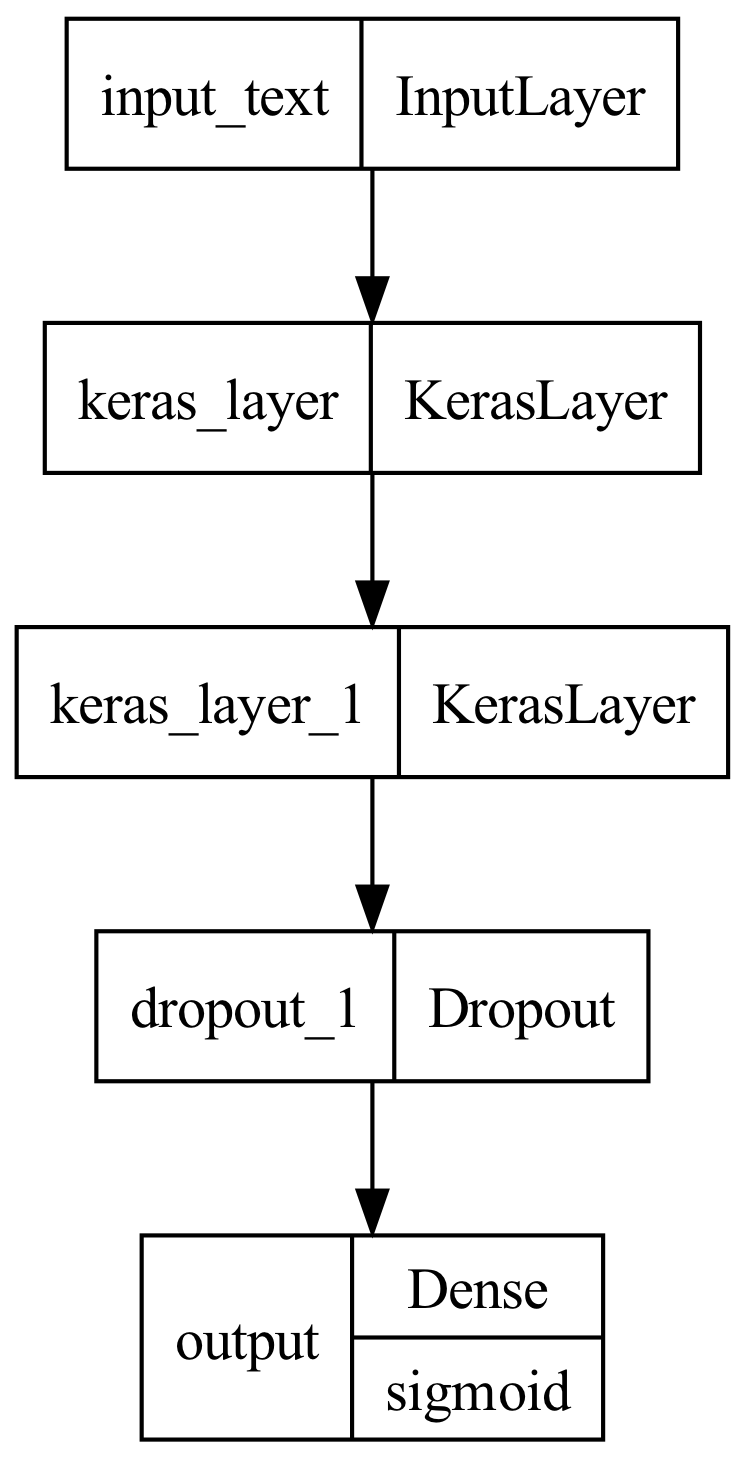

In [46]:
tf.keras.utils.plot_model(
    model, to_file="model1.png",
    rankdir='TB',
    expand_nested=True,
    dpi=300,
    show_layer_activations=True
    )